In [1]:
import pandas as pd                        # CSV 파일 처리를 위해 pandas 임포트
from pathlib import Path                   # 경로 처리를 위해 Path 임포트
import json                                # JSON 파일 처리를 위해 json 임포트

# -------------------------------------------------------
# 경로 설정
# -------------------------------------------------------
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData")  # 루트 경로 설정
CSV_PATH = BASE_DIR / "IDs/Kimjihoo/ASAN_01_Repeatition_Counter/data/metadata_backup.csv"  # metadata.csv 경로

# -------------------------------------------------------
# CSV 로드
# -------------------------------------------------------
df = pd.read_csv(CSV_PATH)                 # metadata.csv 불러오기

# -------------------------------------------------------
# "Nintendo_Therapy" 폴더 & "N06_VISIT6_2" 관련 행 필터링
# -------------------------------------------------------
mask = df["video_path"].str.contains("Nintendo_Therapy", na=False) & df["video_path"].str.contains("N06_VISIT6_2", na=False)  # 조건 필터
filtered = df[mask]                       # 조건 만족 행만 필터링

# -------------------------------------------------------
# keypoints_path 추출
# -------------------------------------------------------
if filtered.empty:                        # 일치하는 행이 없으면 예외 발생
    raise ValueError("❌ Nintendo_Therapy / N06_VISIT6_2 관련 행을 찾지 못했습니다.")
    
keypoints_path = Path(filtered.iloc[0]["keypoints_path"])  # 첫 번째 행의 keypoints_path 경로 추출
print(f"🎯 keypoints_path: {keypoints_path}")               # 경로 출력

# -------------------------------------------------------
# keypoints_path 내부의 모든 JSON 파일 탐색
# -------------------------------------------------------
json_files = sorted(keypoints_path.rglob("*.json"))        # 모든 JSON 파일 정렬 수집
print(f"📂 JSON 파일 개수: {len(json_files)}")             # 개수 출력

# -------------------------------------------------------
# 각 JSON 파일에서 keypoints 데이터 추출
# -------------------------------------------------------
skeleton_data = []                                         # 결과 저장용 리스트 초기화

for jfile in json_files:                                   # 각 JSON 파일 반복
    try:
        with open(jfile, "r", encoding="utf-8") as f:      # 파일 열기
            data = json.load(f)                            # JSON 로드
            if "instance_info" in data:                    # instance_info 존재 확인
                for person in data["instance_info"]:        # 각 사람별로 반복
                    skeleton_data.append({
                        "file": str(jfile),                # 파일 경로
                        "keypoints": person["keypoints"],  # keypoints 좌표
                        "scores": person.get("keypoint_scores", [])  # 점수(선택)
                    })
    except Exception as e:                                 # 오류 처리
        print(f"⚠️ {jfile} 읽는 중 오류: {e}")             # 경고 출력

print(f"✅ keypoints 데이터 추출 완료 ({len(skeleton_data)}개 인스턴스)")  # 총 인스턴스 수 출력


🎯 keypoints_path: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/2_KEYPOINTS/Nintendo_Therapy/N06/N06_VISIT6_2
📂 JSON 파일 개수: 25085
✅ keypoints 데이터 추출 완료 (83059개 인스턴스)


🦴 001000.json → 001000.jpg


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46304 (\N{HANGUL SYLLABLE DEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46988 (\N{HANGUL SYLLABLE RAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


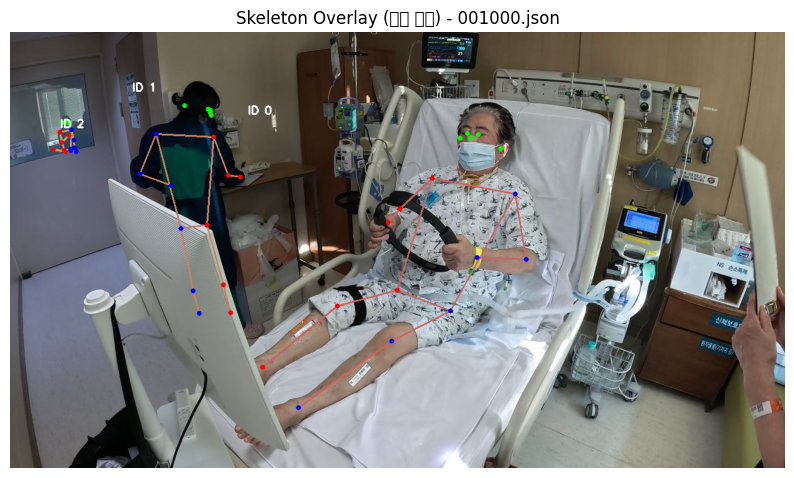

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# -------------------------------------------------------
# CSV 기반 경로 설정
# -------------------------------------------------------
row = filtered.iloc[0]                                 # 필터링된 행 선택
frame_dir = Path(row["frame_path"])                    # 프레임 폴더
keypoints_dir = Path(row["keypoints_path"])            # keypoints 폴더
sample_json = sorted(keypoints_dir.glob("*.json"))[1000]  # 첫 번째 프레임 JSON 선택
frame_path = frame_dir / f"{Path(sample_json).stem}.jpg"  # 동일 이름 프레임

print(f"🦴 {sample_json.name} → {frame_path.name}")

# -------------------------------------------------------
# JSON 로드
# -------------------------------------------------------
with open(sample_json, "r", encoding="utf-8") as f:
    data = json.load(f)

# -------------------------------------------------------
# 프레임 로드
# -------------------------------------------------------
frame = cv2.imread(str(frame_path))
if frame is None:
    raise ValueError(f"⚠️ 프레임을 찾을 수 없습니다: {frame_path}")

# -------------------------------------------------------
# 색상 및 연결 정의 (COCO17)
# -------------------------------------------------------
COLOR_SK = (100, 100, 100)
COLOR_L  = (255, 0, 0)
COLOR_R  = (0, 0, 255)
COLOR_NEUTRAL = (0, 255, 0)

SKELETON_LINKS = [
    (15, 13), (13, 11), (16, 14), (14, 12), (11, 12),
    (5, 11), (6, 12), (5, 6),
    (5, 7), (7, 9), (6, 8), (8, 10)
]
LEFT_POINTS  = [5,7,9,11,13,15]
RIGHT_POINTS = [6,8,10,12,14,16]

# -------------------------------------------------------
# 모든 사람(instance_info) 반복
# -------------------------------------------------------
for pid, person in enumerate(data.get("instance_info", [])):
    kpts = np.array(person["keypoints"])  # (17,2)
    color_scale = 30 * pid                # 사람마다 색 구분용

    # 🔹 Skeleton 연결선
    for i, j in SKELETON_LINKS:
        if i < len(kpts) and j < len(kpts):
            pt1, pt2 = tuple(map(int, kpts[i])), tuple(map(int, kpts[j]))
            cv2.line(frame, pt1, pt2, (100, 100+color_scale, 200), 2)

    # 🔹 Keypoint 점
    for idx, (x, y) in enumerate(kpts):
        if x <= 0 or y <= 0:
            continue
        if idx in LEFT_POINTS:
            color = COLOR_L
        elif idx in RIGHT_POINTS:
            color = COLOR_R
        else:
            color = COLOR_NEUTRAL
        cv2.circle(frame, (int(x), int(y)), 4, color, -1)

    # 🔹 사람 ID 텍스트
    bbox = np.array(person["bbox"]).reshape(-1, 4)[0]
    x1, y1 = int(bbox[0]), int(bbox[1])
    cv2.putText(frame, f"ID {pid}", (x1+5, y1+20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

# -------------------------------------------------------
# Matplotlib 출력 (커널 충돌 없음)
# -------------------------------------------------------
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Skeleton Overlay (모든 사람) - {sample_json.name}")
plt.show()


In [4]:
import cv2                                             # 이미지 처리용 OpenCV 임포트
import json                                            # JSON 파일 입출력용
import numpy as np                                     # 수치 계산용
from pathlib import Path                               # 경로 처리용
from tqdm import tqdm                                  # 진행률 표시용 tqdm

# -------------------------------------------------------
# CSV 기반 경로 설정
# -------------------------------------------------------
row = filtered.iloc[0]                                 # 필터링된 행 선택
frame_dir = Path(row["frame_path"])                    # 프레임 폴더
keypoints_dir = Path(row["keypoints_path"])            # keypoints JSON 폴더
interp_dir = Path(row["interp_json_path"])             # 결과 저장 폴더
interp_dir.mkdir(parents=True, exist_ok=True)          # 폴더 없으면 생성

json_files = sorted(keypoints_dir.glob("*.json"))      # 전체 JSON 정렬 목록

# -------------------------------------------------------
# 유틸 함수 정의
# -------------------------------------------------------
def iou(boxA, boxB):
    """두 bbox 간 IoU 계산"""
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = max(0, boxA[2]-boxA[0]) * max(0, boxA[3]-boxA[1])
    areaB = max(0, boxB[2]-boxB[0]) * max(0, boxB[3]-boxB[1])
    return inter / (areaA + areaB - inter + 1e-6)

def kpt_dist(a, b):
    """두 사람의 keypoints 평균 거리 계산"""
    a, b = np.array(a), np.array(b)
    mask = (a[:,0]>0)&(a[:,1]>0)&(b[:,0]>0)&(b[:,1]>0)
    if not mask.any(): return 1e6
    return np.linalg.norm(a[mask]-b[mask], axis=1).mean()

def color_hist(img, box):
    """bbox 영역의 색상 히스토그램 생성"""
    x1,y1,x2,y2 = [int(v) for v in box]
    crop = img[y1:y2, x1:x2]
    if crop.size==0: return None
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv],[0,1],None,[30,32],[0,180,0,256])
    cv2.normalize(hist,hist)
    return hist

def hist_dist(h1,h2):
    """히스토그램 간 Bhattacharyya 거리 계산"""
    if h1 is None or h2 is None:
        return 1.0
    return cv2.compareHist(h1,h2,cv2.HISTCMP_BHATTACHARYYA)

# -------------------------------------------------------
# 기준 프레임 설정 (1000번째 프레임 ID 0)
# -------------------------------------------------------
ref_index = 1000                                        # 기준 프레임 인덱스
ref_json = json_files[ref_index]                        # 1000번째 JSON 선택

with open(ref_json, "r", encoding="utf-8") as f:        # 기준 JSON 로드
    base_data = json.load(f)

target_person = base_data["instance_info"][0]           # ID 0번 사람 기준 선택
target_bbox = np.array(target_person["bbox"]).reshape(-1,4)[0]
target_kpts = np.array(target_person["keypoints"])
frame_img = cv2.imread(str(frame_dir / f"{ref_json.stem}.jpg"))
target_hist = color_hist(frame_img, target_bbox)

print(f"🎯 기준: {ref_json.name} → ID 0")

# -------------------------------------------------------
# 모든 프레임 순회하면서 동일 인물 추적
# -------------------------------------------------------
for jpath in tqdm(json_files, desc="Tracking same person"):
    frame_path = frame_dir / f"{jpath.stem}.jpg"
    frame_img = cv2.imread(str(frame_path))
    with open(jpath, "r", encoding="utf-8") as f:
        data = json.load(f)

    persons = data.get("instance_info", [])
    if not persons:
        continue

    best_person = None
    best_score = 1e9

    # 각 후보와 기준 인물의 유사도 비교
    for person in persons:
        bbox = np.array(person["bbox"]).reshape(-1,4)[0]
        kpts = np.array(person["keypoints"])
        h = color_hist(frame_img, bbox)

        iou_score = 1 - iou(target_bbox, bbox)          # IoU (1-IoU는 거리처럼 사용)
        kpt_score = kpt_dist(target_kpts, kpts) / 50.0  # 키포인트 거리 (스케일 보정)
        hist_score = hist_dist(target_hist, h)          # 색상 히스토그램 거리

        total = 0.5*iou_score + 0.3*kpt_score + 0.2*hist_score
        if total < best_score:
            best_score = total
            best_person = person

    # 가장 유사한 사람만 남기고 JSON 저장
    if best_person is None:
        continue

    filtered_json = {
        "meta_info": data.get("meta_info", {}),
        "instance_info": [best_person]
    }

    save_path = interp_dir / f"{jpath.name}"
    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(filtered_json, f, ensure_ascii=False, indent=2)

print(f"✅ 기준 프레임 {ref_json.name}의 ID0과 동일 인물 추적 완료 → {interp_dir}")


🎯 기준: 001000.json → ID 0


Tracking same person: 100% 25085/25085 [10:55<00:00, 38.25it/s]

✅ 기준 프레임 001000.json의 ID0과 동일 인물 추적 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/Nintendo_Therapy/N06/N06_VISIT6_2


## 영상 생성

In [26]:
import sys
sys.path.append("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter")
from functions.constants_skeleton.registry import load_skeleton_constants  # 내부 상수 로드용
from functions.render_skeleton_video import render_skeleton_video                    # overlay mp4 생성 함수
from pathlib import Path

# -------------------------------------------------------
# 경로 설정
# -------------------------------------------------------
row = filtered.iloc[0]                                 # 현재 비디오 행 선택
frame_dir = Path(row["frame_path"])                    # 프레임 폴더
interp_json_dir = Path(row["interp_json_path"])        # 우리가 방금 생성한 JSON 폴더
out_mp4 = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/interp_overlay.mp4")       # 출력 mp4 경로

print(f"🎬 영상 생성 시작...")
print(f"📂 Frame dir : {frame_dir}")
print(f"📂 JSON dir  : {interp_json_dir}")
print(f"💾 Output    : {out_mp4}")

# -------------------------------------------------------
# mp4 생성 (render_skeleton_video 함수 사용)
# -------------------------------------------------------
render_skeleton_video(
    frame_dir=str(frame_dir),          # 프레임 경로
    json_dir=str(interp_json_dir),     # JSON 경로
    out_mp4=str(out_mp4),              # 출력 파일
    fps=30,                            # 초당 프레임
    kp_radius=4,                       # 키포인트 점 크기
    line_thickness=2,                  # skeleton 선 두께
    model_type="coco17",               # COCO 17 구조 (12KP면 yolo12)
    flip_horizontal=False              # 좌우 반전 여부
)


🎬 영상 생성 시작...
📂 Frame dir : /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/1_FRAME/Nintendo_Therapy/N06/N06_VISIT6_2
📂 JSON dir  : /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/Nintendo_Therapy/N06/N06_VISIT6_2
💾 Output    : /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/interp_overlay.mp4


N06_VISIT6_2:  60% 15148/25085 [05:34<03:39, 45.28frame/s]


KeyboardInterrupt: 

## keypoints 불러오기

Loading keypoints: 100% 25085/25085 [00:18<00:00, 1351.72it/s]


<Figure size 1400x600 with 0 Axes>

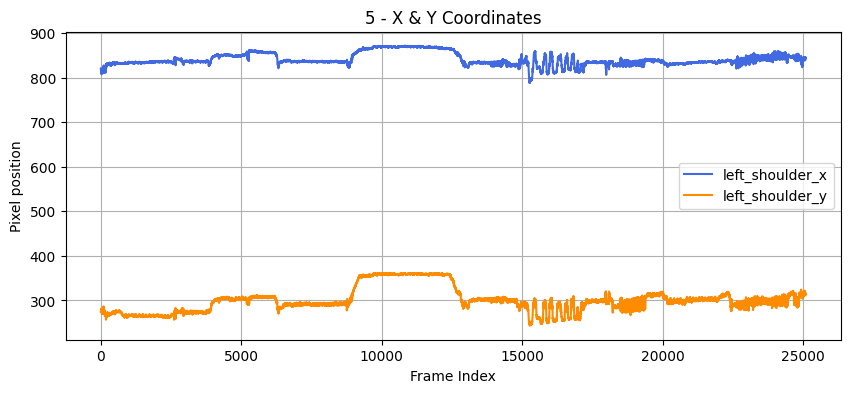

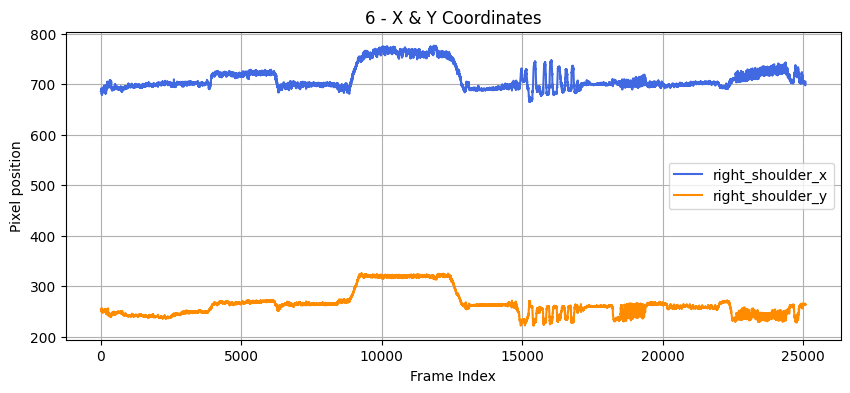

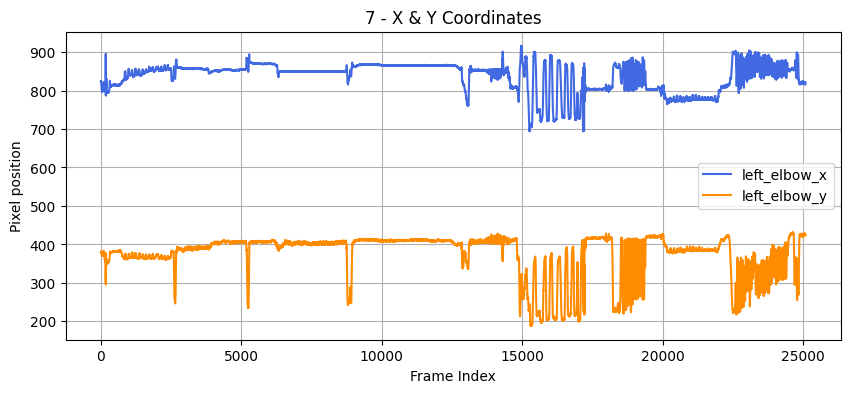

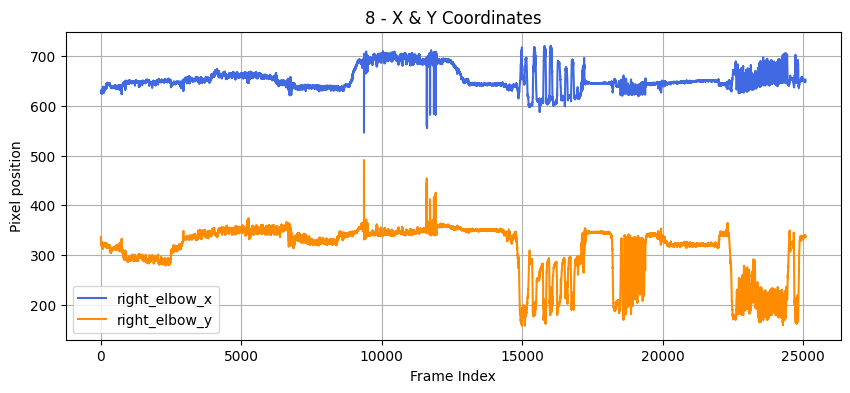

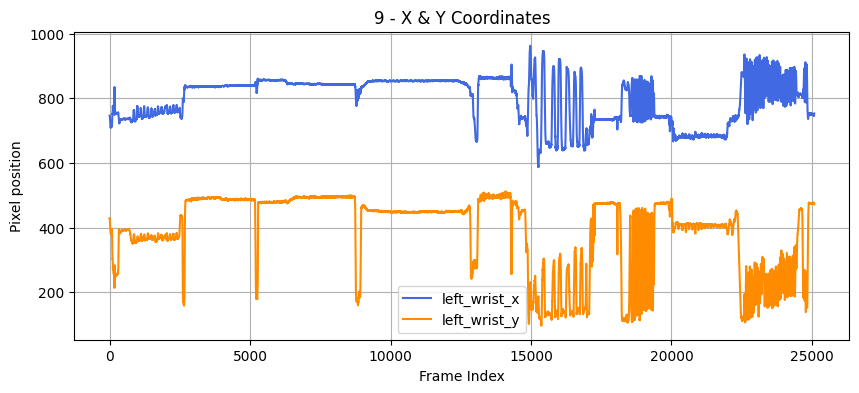

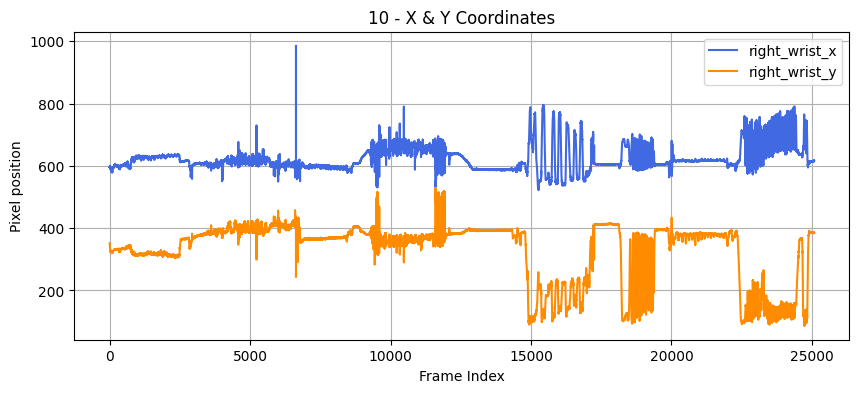

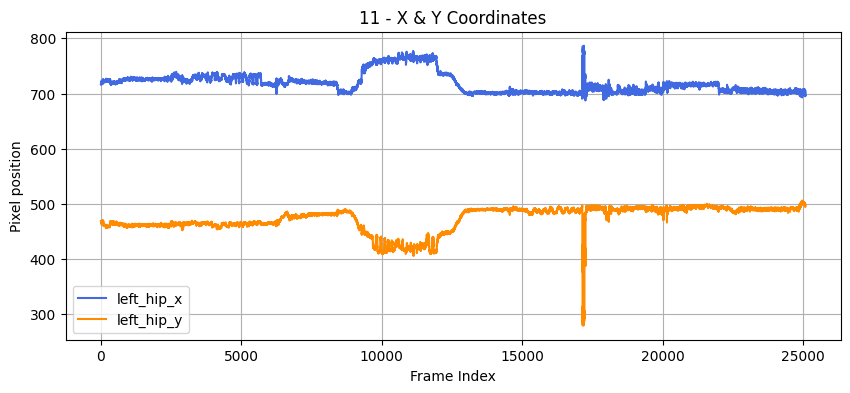

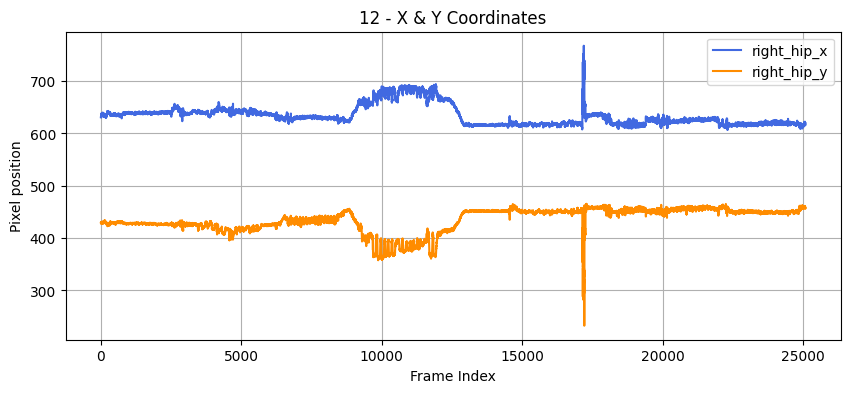

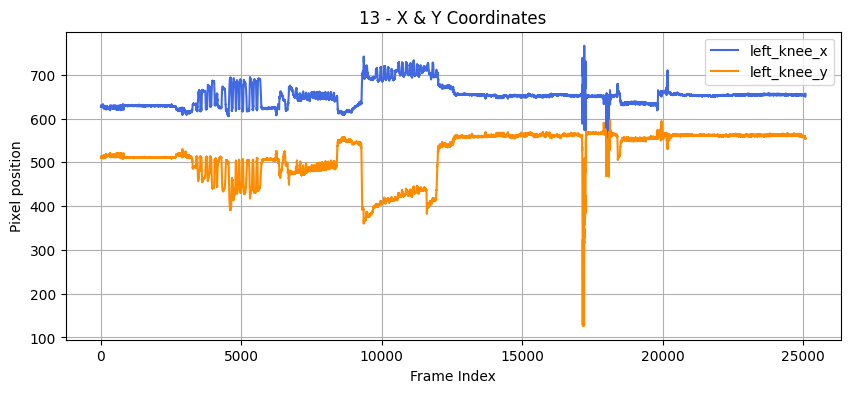

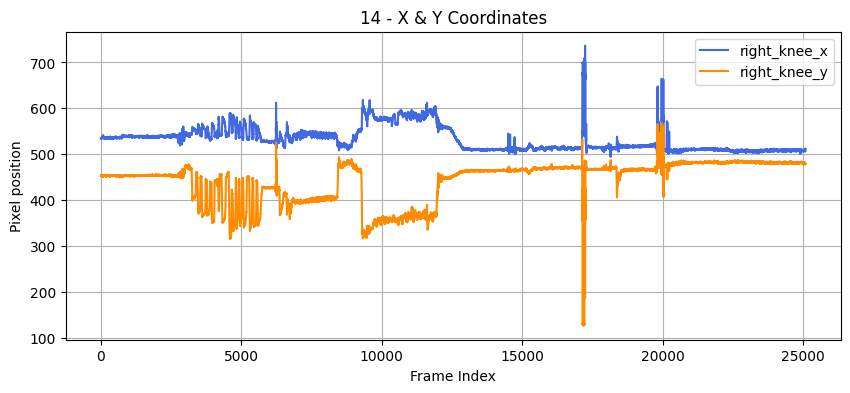

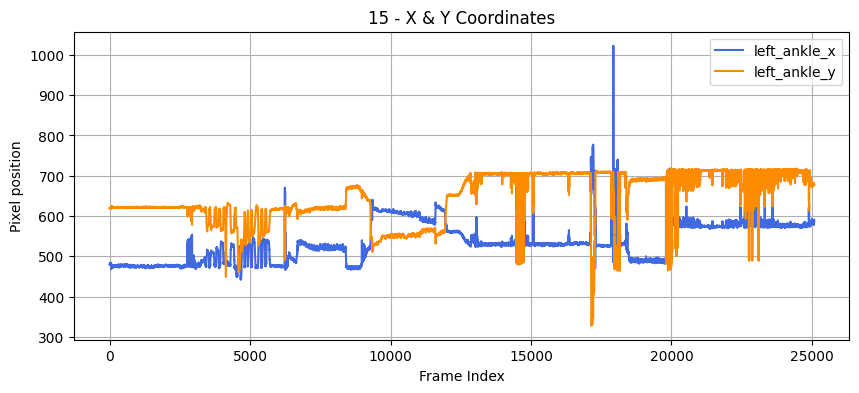

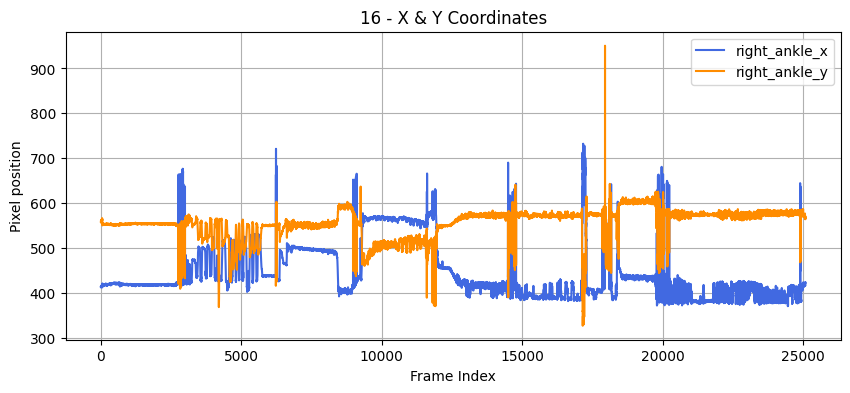

In [43]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# 경로 설정
# -------------------------------------------------------
row = filtered.iloc[0]                                 # 현재 비디오 행 선택
interp_json_dir = Path(row["interp_json_path"])        # 추적된 JSON 폴더
json_files = sorted(interp_json_dir.glob("*.json"))    # 모든 JSON 정렬

# -------------------------------------------------------
# Keypoints (5~16) 좌표 수집
# -------------------------------------------------------
keypoint_indices = list(range(5, 17))                  # left_shoulder~right_ankle (COCO 5~16)
x_coords = {k: [] for k in keypoint_indices}           # x좌표 저장 딕셔너리
y_coords = {k: [] for k in keypoint_indices}           # y좌표 저장 딕셔너리

for jpath in tqdm(json_files, desc="Loading keypoints"):
    with open(jpath, "r", encoding="utf-8") as f:
        data = json.load(f)

    persons = data.get("instance_info", [])
    if not persons:
        for k in keypoint_indices:
            x_coords[k].append(np.nan)
            y_coords[k].append(np.nan)
        continue

    kpts = np.array(persons[0]["keypoints"])           # (17,2)
    for k in keypoint_indices:
        x_coords[k].append(kpts[k, 0])
        y_coords[k].append(kpts[k, 1])

# -------------------------------------------------------
# NumPy 변환
# -------------------------------------------------------
frames = np.arange(len(json_files))
x_arr = {k: np.array(v) for k, v in x_coords.items()}
y_arr = {k: np.array(v) for k, v in y_coords.items()}

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# COCO 5~16 이름 매핑
kp_names = {
    5: "left_shoulder", 6: "right_shoulder",
    7: "left_elbow", 8: "right_elbow",
    9: "left_wrist", 10: "right_wrist",
    11: "left_hip", 12: "right_hip",
    13: "left_knee", 14: "right_knee",
    15: "left_ankle", 16: "right_ankle"
}

# -------------------------------------------------------
# 각 keypoint별로 x/y 두 선을 한 plot에 그림
# -------------------------------------------------------
for k in keypoint_indices:
    plt.figure(figsize=(10, 4))
    plt.plot(frames, x_arr[k], color="royalblue", label=f"{kp_names[k]}_x")
    plt.plot(frames, y_arr[k], color="darkorange", label=f"{kp_names[k]}_y")
    plt.title(f"{k} - X & Y Coordinates")
    plt.xlabel("Frame Index")
    plt.ylabel("Pixel position")
    plt.legend()
    plt.grid(True)
    plt.show()



## 하나만 IQR 분석

✅ Keypoint 12 (left_shoulder) IQR 결과
X축: Q1=618.48, Q3=639.95, IQR=21.47, 하한=543.34, 상한=715.09
Y축: Q1=425.10, Q3=451.57, IQR=26.48, 하한=332.43, 상한=544.24
X 이상치 개수: 22개, Y 이상치 개수: 39개


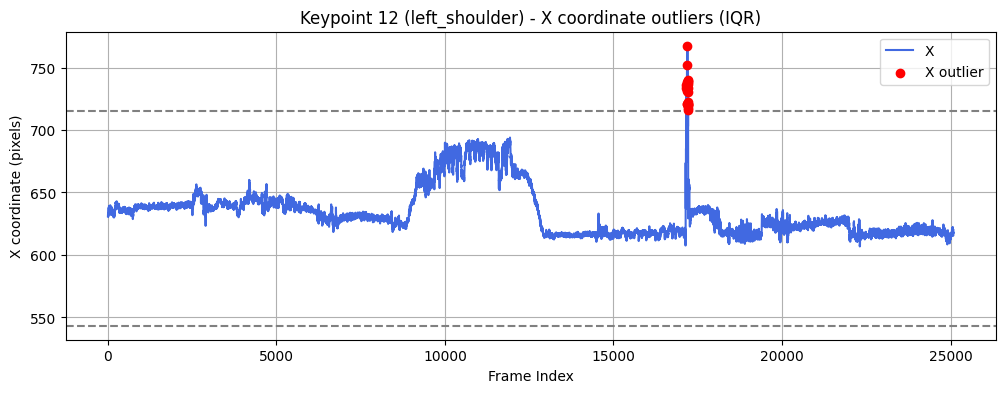

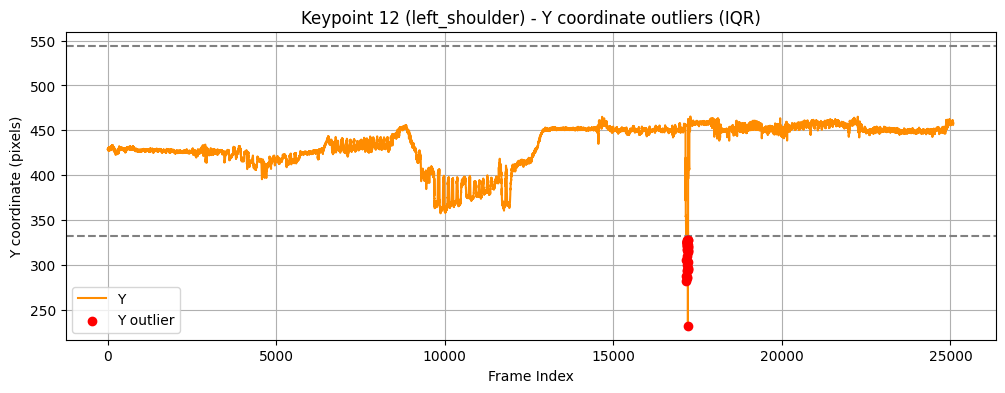

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# keypoint 5: left_shoulder
# -------------------------------------------------------
k = 12
x_vals = np.array(x_arr[k])        # X 좌표 배열
y_vals = np.array(y_arr[k])        # Y 좌표 배열
frames = np.arange(len(x_vals))    # 프레임 인덱스

# -------------------------------------------------------
# IQR 계산 함수
# -------------------------------------------------------
def find_outliers_iqr(data):
    """IQR을 이용해 이상치 인덱스를 반환"""
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 3.5 * iqr
    upper = q3 + 3.5 * iqr
    outlier_idx = np.where((data < lower) | (data > upper))[0]
    return outlier_idx, lower, upper, q1, q3, iqr

# -------------------------------------------------------
# X, Y 각각 이상치 탐지
# -------------------------------------------------------
out_x, lower_x, upper_x, q1x, q3x, iqrx = find_outliers_iqr(x_vals)
out_y, lower_y, upper_y, q1y, q3y, iqry = find_outliers_iqr(y_vals)

print(f"✅ Keypoint {k} (left_shoulder) IQR 결과")
print(f"X축: Q1={q1x:.2f}, Q3={q3x:.2f}, IQR={iqrx:.2f}, 하한={lower_x:.2f}, 상한={upper_x:.2f}")
print(f"Y축: Q1={q1y:.2f}, Q3={q3y:.2f}, IQR={iqry:.2f}, 하한={lower_y:.2f}, 상한={upper_y:.2f}")
print(f"X 이상치 개수: {len(out_x)}개, Y 이상치 개수: {len(out_y)}개")

# -------------------------------------------------------
# 시각화
# -------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(frames, x_vals, color='royalblue', label='X')
plt.scatter(frames[out_x], x_vals[out_x], color='red', label='X outlier', zorder=3)
plt.axhline(lower_x, color='gray', linestyle='--')
plt.axhline(upper_x, color='gray', linestyle='--')
plt.title(f"Keypoint {k} (left_shoulder) - X coordinate outliers (IQR)")
plt.xlabel("Frame Index")
plt.ylabel("X coordinate (pixels)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(frames, y_vals, color='darkorange', label='Y')
plt.scatter(frames[out_y], y_vals[out_y], color='red', label='Y outlier', zorder=3)
plt.axhline(lower_y, color='gray', linestyle='--')
plt.axhline(upper_y, color='gray', linestyle='--')
plt.title(f"Keypoint {k} (left_shoulder) - Y coordinate outliers (IQR)")
plt.xlabel("Frame Index")
plt.ylabel("Y coordinate (pixels)")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
import os
import numpy as np
import json
from pathlib import Path

# -------------------------------------------------------
# 경로 및 데이터 로드
# -------------------------------------------------------
row = filtered.iloc[0]                                  # 필터링된 행 선택
interp_json_dir = Path(row["interp_json_path"])         # 추적된 JSON 폴더
json_files = sorted(interp_json_dir.glob("*.json"))     # 모든 JSON 정렬

# -------------------------------------------------------
# 사용자 설정
# -------------------------------------------------------
keypoint_idx = 12
coord_type = input("분석할 좌표 축을 선택하세요 (x / y): ").strip().lower()

if coord_type not in ["x", "y"]:
    raise ValueError("좌표 축은 'x' 또는 'y' 중 하나여야 합니다.")

coord_dim = 0 if coord_type == "x" else 1

# -------------------------------------------------------
# 선택된 좌표축 값 추출
# -------------------------------------------------------
vals = []
for jpath in json_files:
    try:
        with open(jpath, "r", encoding="utf-8") as f:
            data = json.load(f)
        persons = data.get("instance_info", [])
        if persons:
            kpts = np.array(persons[0]["keypoints"])
            vals.append(kpts[keypoint_idx, coord_dim])
        else:
            vals.append(np.nan)
    except Exception:
        vals.append(np.nan)

vals = np.array(vals)

# -------------------------------------------------------
# IQR 계산
# -------------------------------------------------------
q1 = np.nanpercentile(vals, 25)
q3 = np.nanpercentile(vals, 75)
iqr = q3 - q1
lower = q1 - 3.5 * iqr
upper = q3 + 3.5 * iqr

outlier_idx = np.where((vals < lower) | (vals > upper))[0]
outlier_files = [json_files[i] for i in outlier_idx]

print(f"✅ IQR 기준 {coord_type.upper()}축 outlier {len(outlier_idx)}개 발견")
print(f"하한={lower:.2f}, 상한={upper:.2f}")
if outlier_idx.size > 0:
    print("예시:", [f.name for f in outlier_files[:10]])

# -------------------------------------------------------
# 삭제 수행
# -------------------------------------------------------
deleted = 0
for fpath in outlier_files:
    try:
        os.remove(fpath)
        deleted += 1
    except Exception as e:
        print(f"⚠️ {fpath.name} 삭제 실패: {e}")

print(f"🗑️  총 {deleted}개 JSON 파일 삭제 완료 (outlier 제거됨)")


✅ IQR 기준 Y축 outlier 42개 발견
하한=332.43, 상한=544.24
예시: ['000044.json', '009685.json', '017155.json', '017158.json', '017159.json', '017169.json', '017170.json', '017171.json', '017172.json', '017178.json']
🗑️  총 42개 JSON 파일 삭제 완료 (outlier 제거됨)


In [42]:
import sys
# -------------------------------------------------------
# 기본 경로 설정
# -------------------------------------------------------
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter")

sys.path.append(BASE_DIR)

import json
from pathlib import Path
from mmpose.apis import init_model as init_pose_estimator
from functions.reextract_missing_keypoints import reextract_missing_keypoints


# -------------------------------------------------------
# CSV 기반 폴더 가져오기
# -------------------------------------------------------
row = filtered.iloc[0]                                   # 현재 대상 비디오 행 선택
frame_dir = str(row["frame_path"])                        # 프레임 폴더
json_dir  = str(row["interp_json_path"])                  # JSON 폴더 (outlier 제거 후)
file_name = Path(row["video_path"]).stem                  # 비디오 이름
n_extracted_frames = len(sorted(Path(frame_dir).glob("*.jpg")))  # 총 프레임 수

# -------------------------------------------------------
# 모델 설정 (Sapiens 기반)
# -------------------------------------------------------
pose_cfg  = str(BASE_DIR / "configs/sapiens/sapiens_0.3b-210e_coco-1024x768.py")
pose_ckpt = str(BASE_DIR / "checkpoints/sapiens/sapiens_0.3b_coco_best_coco_AP_796.pth")

print(f"📘 Pose Config : {pose_cfg}")
print(f"💾 Pose Checkpoint : {pose_ckpt}")

# -------------------------------------------------------
# Pose Estimator 초기화 (mmpose)
# -------------------------------------------------------
pose_estimator = init_pose_estimator(
    pose_cfg,
    pose_ckpt,
    device="cuda:0",
    cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False)))
)

# -------------------------------------------------------
# 누락된 프레임만 재추출
# -------------------------------------------------------
print(f"🎯 재추출 대상 폴더: {json_dir}")
print(f"🎥 총 프레임 수: {n_extracted_frames}")

count = reextract_missing_keypoints(
    file_name=file_name,
    frame_dir=frame_dir,
    json_dir=json_dir,
    n_extracted_frames=n_extracted_frames,
    pose_estimator=pose_estimator
)

print(f"✅ 재추출 완료 → 최종 JSON 개수: {count}")


📘 Pose Config : /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/configs/sapiens/sapiens_0.3b-210e_coco-1024x768.py
💾 Pose Checkpoint : /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/checkpoints/sapiens/sapiens_0.3b_coco_best_coco_AP_796.pth
Loads checkpoint by local backend from path: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/checkpoints/sapiens/sapiens_0.3b_coco_best_coco_AP_796.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: head.deconv_layers.1.weight, head.deconv_layers.1.bias, head.deconv_layers.1.running_mean, head.deconv_layers.1.running_var, head.deconv_layers.4.weight, head.deconv_layers.4.bias, head.deconv_layers.4.running_mean, head.deconv_layers.4.running_var, head.conv_layers.1.weight, head.conv_layers.1.bias, head.conv_layers.1.running_mean, head.conv_layers.1.running_var, head.conv_layers.4.weight, 

N06_VISIT6_2 (re-infer): 100% 42/42 [00:22<00:00,  1.84frame/s]

[INFO] N06_VISIT6_2: 최종 JSON 개수 25085
✅ 재추출 완료 → 최종 JSON 개수: 25085
